<a href="https://colab.research.google.com/github/053steve/CRNN-model-text-recognition/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup all basic stuff for colab and github integration

In [11]:

COLAB = True
GIT_REPOSITORY = "CRNN-model-text-recognition"
FILE_NAME = "notebook.ipynb"
UNZIP_DATASET = True

if COLAB:    
    # PARENT_DIRECTORY_PATH = "/content"
    # In case you want to clone in your drive:
    PARENT_DIRECTORY_PATH = "/content"
    DATASET_DIRECTORY_PATH = "/content/gdrive/My\ Drive/datasets/captcha"
    SOURCE_DATASET_ZIP_FILE = "archive.zip"
    SOURCE_DATASET_ZIP_PATH = DATASET_DIRECTORY_PATH + "/" + SOURCE_DATASET_ZIP_FILE
    PROJECT_PATH = PARENT_DIRECTORY_PATH + "/" + GIT_REPOSITORY
    %cd "{PARENT_DIRECTORY_PATH}"
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    DATASET_DIRECTORY_PATH = "/Users/Steve/datasets/captcha"
    SOURCE_DATASET_ZIP_FILE = "archive.zip"
    SOURCE_DATASET_ZIP_PATH = DATASET_DIRECTORY_PATH + "/" + SOURCE_DATASET_ZIP_FILE

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp


In [3]:
cpu_count = mp.cpu_count()
print(cpu_count)
if COLAB:
    worker_num = cpu_count
else:
    worker_num = 0

2


In [13]:
if UNZIP_DATASET:
    print("unzip source in path " + SOURCE_DATASET_ZIP_PATH)
    # !unzip '/content/gdrive/My Drive/datasets/captcha/archive.zip'
    !unzip {SOURCE_DATASET_ZIP_PATH}

unzip source in path /content/gdrive/My\ Drive/datasets/captcha/archive.zip
Archive:  /content/gdrive/My Drive/datasets/captcha/archive.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2ce

Split test data, train data

In [14]:
data_path = 'samples/'
all_image_list = os.listdir(data_path)
# print(all_image_list)
print(len(all_image_list))
print(np.unique([len(image.split(".")[0]) for image in all_image_list]))

for idx, image in enumerate(all_image_list):
    if len(image.split(".")[0]) != 5:
           print(idx, image)

all_image_list.remove("samples")
print(len(all_image_list))

image_fns_train, image_fns_test = train_test_split(all_image_list, random_state=0)
print(len(image_fns_train), len(image_fns_test))


1071
[5 7]
647 samples
1070
802 268


Define Character maps

In [15]:
image_ns = [image_fn.split(".")[0] for image_fn in all_image_list]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))

print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [16]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


Define data loader

In [17]:
batch_size = 16

CaptchaDataSet class will be use to create mapped style data sets

In [20]:
class CaptchaDataSet(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
    
    def __len__(self):
        return len(self.image_fns)

    # during get it will transform image to tensor and normalise the image
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text


    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)    
        

In [24]:
trainset = CaptchaDataSet(data_path, image_fns_train) 
testset = CaptchaDataSet(data_path, image_fns_test)


train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=worker_num, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=worker_num, shuffle=False)
print(len(train_loader), len(test_loader))

51 17


In [25]:
data_iter = iter(train_loader)
image_batch, text_batch = next(data_iter)
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('bw5nf', '8wy7d', 'fyfbn', 'ewnx8', 'mmy5n', 'e8dxn', '6g45w', 'en32e', 'dd5w5', 'px2xp', '2gyb6', 'md344', 'nbfx5', 'ec6pm', 'cb8cf', '5mfff')


Define the model

In [ ]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
resnet = resnet18(pretrained=True)
# print(resnet)

/Users/Steve/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Steve/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class CRNN(nn.Module):

    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        # CNN Convolutional layers
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(1024, 256)

        # RNN recurrent layers
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)

    def forward(self, batch):

        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)

        T = batch.size(1)
        
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])

        batch, hidden = self.rnn1(batch)

        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch



In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('p8ngx', 'xxbm5', '6ng6w', 'yf28d', 'e667x', 'gm6nn', '3cpwb', 'ndg2b', 'mcg43', '6gnm3', 'ffpxf', 'dd5w5', 'yd38e', '4exnn', 'bwmee', 'efg72')
torch.Size([10, 16, 20])


Define loss

In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    # print(text_batch_logps.shape)
    # print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    # print(text_batch_targets)
    # print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
compute_loss(text_batch, text_batch_logits)

torch.Size([10, 16, 20])
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       dtype=torch.int32)
tensor([16,  7, 15, 13, 18, 18, 18,  8, 14,  4,  5, 15, 13,  5, 17, 19, 12,  1,
         7, 10, 11,  5,  5,  6, 18, 13, 14,  5, 15, 15,  2,  9, 16, 17,  8, 15,
        10, 13,  1,  8, 14,  9, 13,  3,  2,  5, 13, 15, 14,  2, 12, 12, 16, 18,
        12, 10, 10,  4, 17,  4, 19, 10,  2,  7, 11,  3, 11, 18, 15, 15,  8, 17,
        14, 11, 11, 11, 12, 13,  6,  1], dtype=torch.int32)
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


tensor(4.7408, grad_fn=<MeanBackward0>)

Train the model

In [ ]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [ ]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

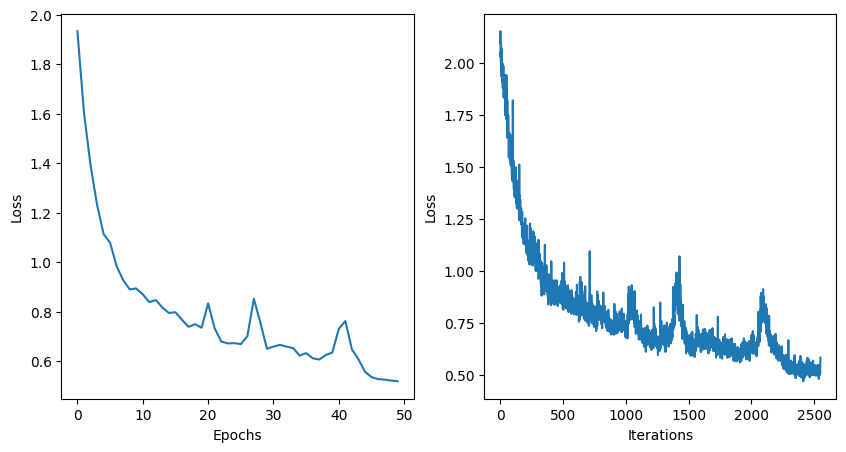

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

Make prediction

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
print(results_train.shape)
results_train.head()

In [ ]:
print(results_test.shape)
results_test.head()

In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()